# Demonstrate energy ratio syntax

FLASC v1.4 uses a new polars-based (https://www.pola.rs/) code to speed up the calculation of energy ratio.  However, we've tried to keep consistency with the code to date but continuing to use the same pandas-based conventions for the user-facing data while the transitions to polars dataframes is hidden within several new modules.

This notebook illustrates the usage of these new modules

In [1]:
from pathlib import Path

import floris.layout_visualization as layoutviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from floris import FlorisModel, TimeSeries

from flasc.analysis import energy_ratio as erp
from flasc.analysis.energy_ratio_input import EnergyRatioInput

# Generate dataset with FLORIS

Use FLORIS to make a simple data set consisting of 3 turbines.  Two turbines are aligned in a westerly flow, a third turbine will act as reference.  The first turbine in the row operates normally in the baseline data set, and is yawed in the wake steering case

Text(0, 0.5, 'y coordinate [m]')

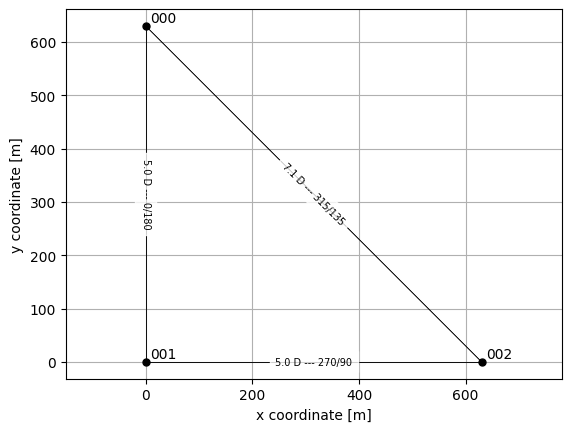

In [2]:
file_path = Path.cwd()
fm_path = file_path / "../floris_input_artificial/gch.yaml"
fm = FlorisModel(fm_path)
fm.set(layout_x=[0, 0, 5 * 126], layout_y=[5 * 126, 0, 0])

# # Show the wind farm
ax = layoutviz.plot_turbine_points(fm)
layoutviz.plot_turbine_labels(fm, ax=ax)
layoutviz.plot_waking_directions(fm, ax=ax)
ax.grid()
ax.set_xlabel("x coordinate [m]")
ax.set_ylabel("y coordinate [m]")

Num Points 500


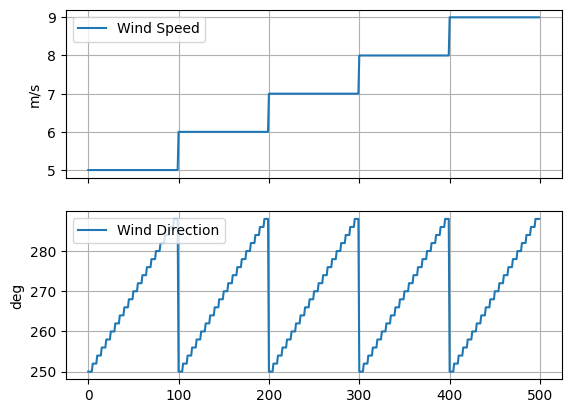

In [3]:
# Create a time history of points where the wind speed and
# wind direction step different combinations
ws_points = np.arange(5.0, 10.0, 1.0)
wd_points = np.arange(
    250.0,
    290.0,
    2,
)
num_points_per_combination = 5  # How many "seconds" per combination

# I know this is dumb but will come back, can't quite work out the numpy version
ws_array = []
wd_array = []
for ws in ws_points:
    for wd in wd_points:
        for i in range(num_points_per_combination):
            ws_array.append(ws)
            wd_array.append(wd)
t = np.arange(len(ws_array))
wd_array = np.array(wd_array)
ws_array = np.array(ws_array)

print(f"Num Points {len(t)}")

fig, axarr = plt.subplots(2, 1, sharex=True)
axarr[0].plot(t, ws_array, label="Wind Speed")
axarr[0].set_ylabel("m/s")
axarr[0].legend()
axarr[0].grid(True)
axarr[1].plot(t, wd_array, label="Wind Direction")
axarr[1].set_ylabel("deg")
axarr[1].legend()
axarr[1].grid(True)

In [4]:
# Compute the power of the second turbine for two cases
# Baseline: The front turbine is aligned to the wind
# WakeSteering: The front turbine is yawed 25 deg
time_series = TimeSeries(
    wind_directions=wd_array, wind_speeds=ws_array, turbulence_intensities=0.06
)
fm.set(
    wind_data=time_series,
)
fm.run()
power_baseline_ref = fm.get_turbine_powers().squeeze()[:, 0].flatten() / 1000.0
power_baseline_control = fm.get_turbine_powers().squeeze()[:, 1].flatten() / 1000.0
power_baseline_downstream = fm.get_turbine_powers().squeeze()[:, 2].flatten() / 1000.0

yaw_angles = np.zeros([len(t), 3]) * 25
yaw_angles[:, 1] = 25  # Set control turbine yaw angles to 25 deg
fm.set(yaw_angles=yaw_angles)
fm.run()
power_wakesteering_ref = fm.get_turbine_powers().squeeze()[:, 0].flatten() / 1000.0
power_wakesteering_control = fm.get_turbine_powers().squeeze()[:, 1].flatten() / 1000.0
power_wakesteering_downstream = fm.get_turbine_powers().squeeze()[:, 2].flatten() / 1000.0

## Assemble the pandas dataframes and add some noise to the wind speed and direction signals

In [5]:
# Create alternative versions of each of the above dataframes where the wd/ws are perturbed by noise
df_baseline_noisy_pd = pd.DataFrame(
    {
        "wd": wd_array + np.random.randn(len(wd_array)) * 2,
        "ws": ws_array + np.random.randn(len(ws_array)),
        "pow_ref": power_baseline_ref,
        "pow_000": power_baseline_ref,
        "pow_001": power_baseline_control,
        "pow_002": power_baseline_downstream,
    }
)

df_wakesteering_noisy_pd = pd.DataFrame(
    {
        "wd": wd_array + np.random.randn(len(wd_array)) * 2,
        "ws": ws_array + np.random.randn(len(ws_array)),
        "pow_ref": power_wakesteering_ref,
        "pow_000": power_wakesteering_ref,
        "pow_001": power_wakesteering_control,
        "pow_002": power_wakesteering_downstream,
    }
)

color_palette = sns.color_palette("Paired", 4)[::-1]

# Energy Ratio Input

In the new syntax, the first step in computing an energy is building an EnergyRatioInput object.  This is analagous to the construction of an energy ratio suite object in prior versions.  

The inputs to provide are the list of dataframes, and the names of those dataframes.  An optional 3rd input is how many blocks to divide the data into, this will be used in block bootstrapping and is done here to save time.  Setting the number of blocks equal to the number of rows in the dataframe with the smallest number of rows approximates non-block boostreapping/

In [6]:
er_in = EnergyRatioInput(
    [df_baseline_noisy_pd, df_wakesteering_noisy_pd], ["baseline", "wakesteering"], num_blocks=10
)

# Computing the energy ratio

Computing the energy ratio is now done by passing the above er_in into the compute_energy_ratio function.  The energy ratio expects to be instructed which sets of turbines to average to produce the wind speed, wind direction, reference power and test power.  However, there is also the option to use pre-defined values, in which case the columns 'wd', 'ws' and/or 'pow_ref' need to be already defined in the dataframes.

In this example since wd,ws,and pow_ref are defined, we'll use that option here

#### Compute the energy ratio of turbine 2, with respect to turbine 0

In [7]:
num_bootstrap = 20

In [8]:
er_out = erp.compute_energy_ratio(
    er_in,
    test_turbines=[2],
    use_predefined_ref=True,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_bin_overlap_radius=0.0,
    N=num_bootstrap,
)

# EnergyRatioOutput

The output of compute_energy_ratio is an EnergyRatioOutput object which contains both the pandas dataframe of energy ratios as defined by the EnergyRatioIn and parameters to compute_energy_ratio, as well as the EnergyRatioIn object itself.  

The EnergyRatioOutput object includes member functions for visualizing the results

<Axes: title={'center': 'Energy Ratio'}, xlabel='Wind Direction (deg)', ylabel='Energy Ratio'>

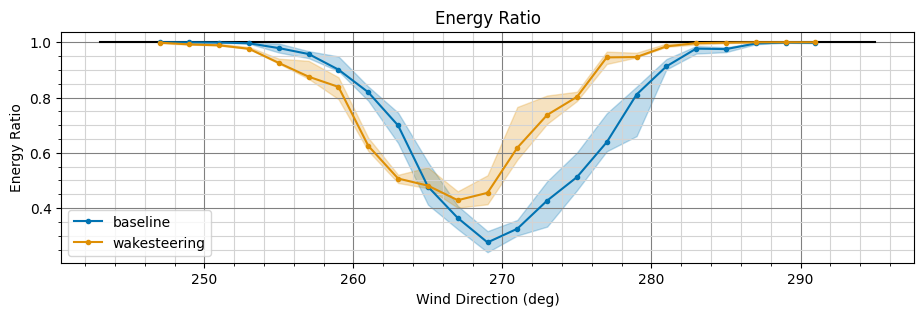

In [9]:
# Plot the resulting the energy ratios without the distribution plots
er_out.plot_energy_ratios(
    show_wind_direction_distribution=False, show_wind_speed_distribution=False
)

array([<Axes: title={'center': 'Energy Ratio'}, ylabel='Energy Ratio'>,
       <Axes: title={'center': 'Number of Points per Bin'}, ylabel='Number of Points'>,
       <Axes: title={'center': 'Minimum Number of Points per Bin'}, xlabel='Wind Direction (deg)', ylabel='Wind Speed (m/s)'>],
      dtype=object)

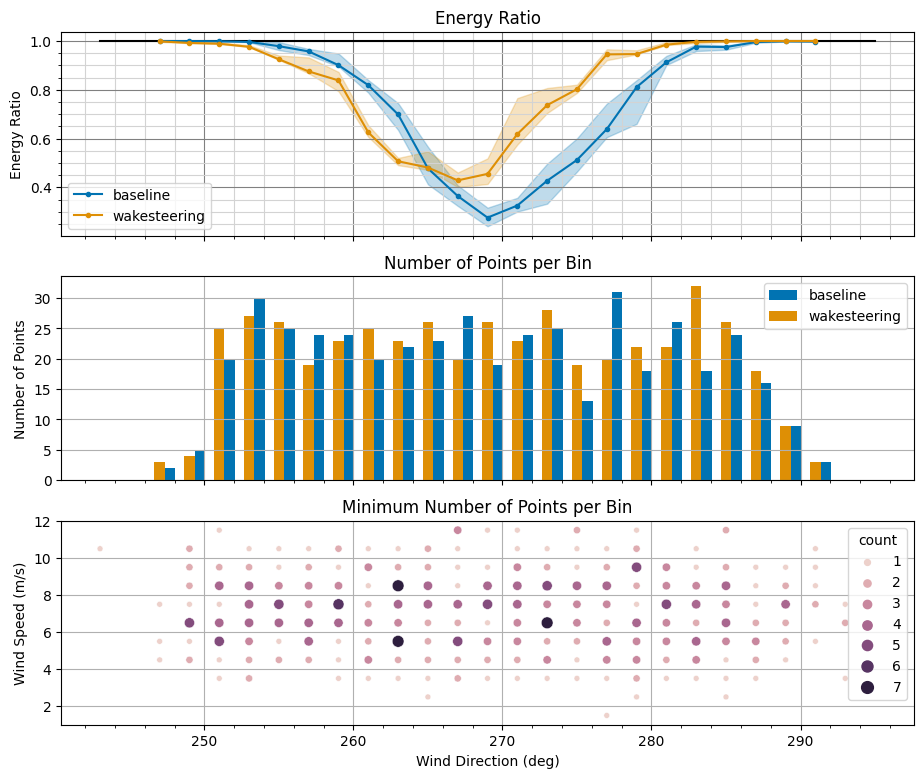

In [10]:
# Plot the resulting the energy ratios with the distribution plots
er_out.plot_energy_ratios(show_wind_direction_distribution=True, show_wind_speed_distribution=True)

# Calculating Uplift

Calculate the energy ratios again, this time specifying to also calculate the percent change in energy ratio from the baseline case to the wake steering case and storing that result in an column named "uplift"

In [11]:
er_out = erp.compute_energy_ratio(
    er_in,
    test_turbines=[2],
    use_predefined_ref=True,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_bin_overlap_radius=0.0,
    N=num_bootstrap,
    uplift_pairs=[("baseline", "wakesteering")],
    uplift_names=["uplift"],
)

array([<Axes: title={'center': 'Uplift in Energy Ratio'}, ylabel='Percent Change'>,
       <Axes: title={'center': 'Minimum of Points per Bin'}, ylabel='Number of Points'>,
       <Axes: title={'center': 'Minimum Number of Points per Bin'}, xlabel='Wind Direction (deg)', ylabel='Wind Speed (m/s)'>],
      dtype=object)

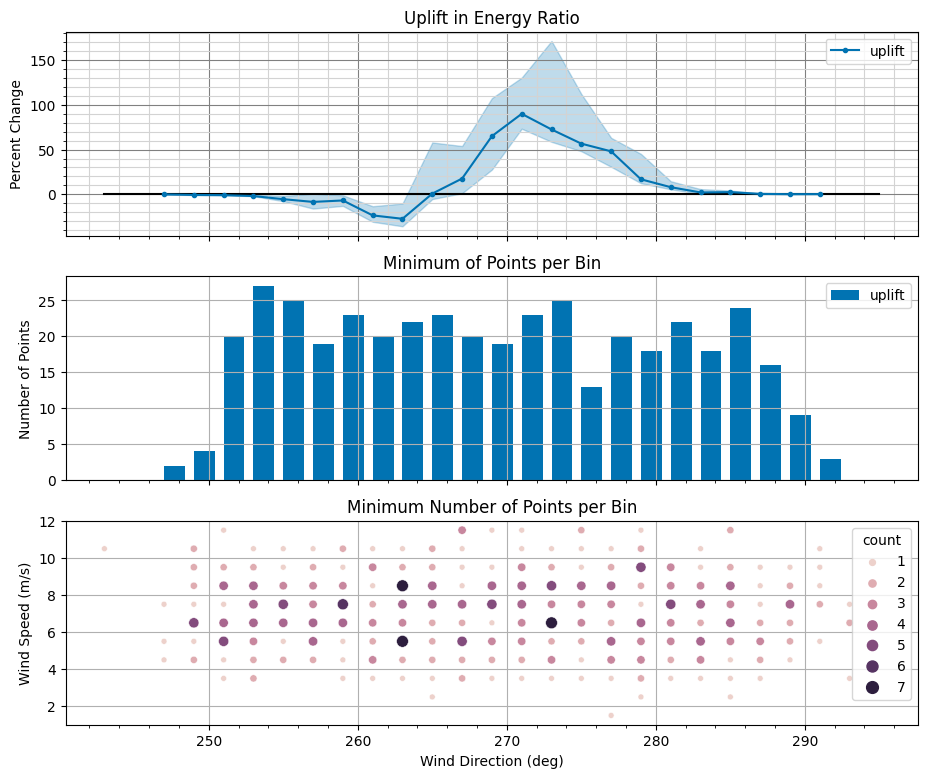

In [12]:
er_out.plot_uplift()

# Change uncertainty calculation
Switch to 200 bootstrap iterations with confidence shown between 20-80%

In [13]:
er_out = erp.compute_energy_ratio(
    er_in,
    test_turbines=[2],
    use_predefined_ref=True,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_bin_overlap_radius=0.0,
    N=200,
    uplift_pairs=[("baseline", "wakesteering")],
    uplift_names=["uplift"],
    percentiles=[20, 80],
)

array([<Axes: title={'center': 'Energy Ratio'}, ylabel='Energy Ratio'>,
       <Axes: title={'center': 'Number of Points per Bin'}, ylabel='Number of Points'>,
       <Axes: title={'center': 'Minimum Number of Points per Bin'}, xlabel='Wind Direction (deg)', ylabel='Wind Speed (m/s)'>],
      dtype=object)

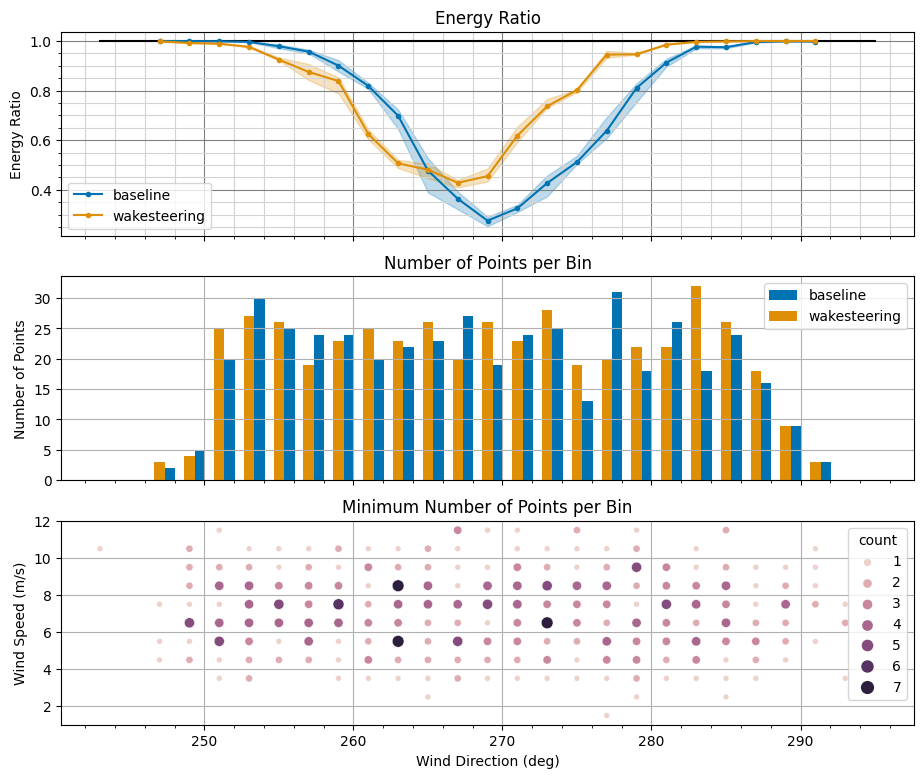

In [14]:
er_out.plot_energy_ratios()

array([<Axes: title={'center': 'Uplift in Energy Ratio'}, ylabel='Percent Change'>,
       <Axes: title={'center': 'Minimum of Points per Bin'}, ylabel='Number of Points'>,
       <Axes: title={'center': 'Minimum Number of Points per Bin'}, xlabel='Wind Direction (deg)', ylabel='Wind Speed (m/s)'>],
      dtype=object)

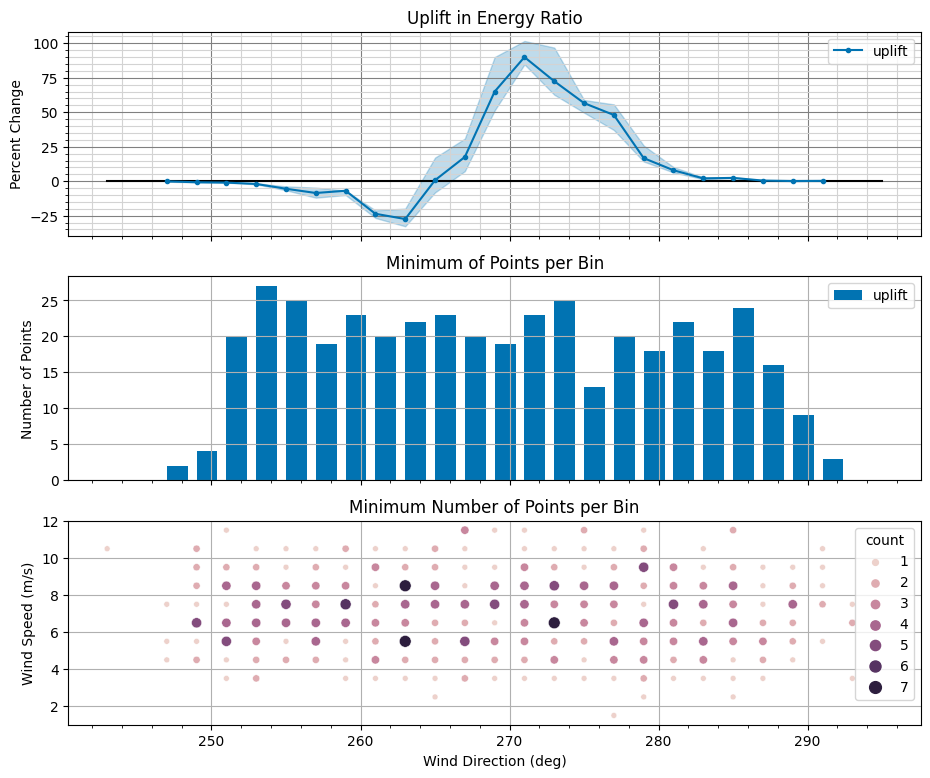

In [15]:
er_out.plot_uplift()